# Hands-On Session No. 5
## (Training CNNs to solve Inverse Problems)




### Q1: Denoising: Load the MNIST data and create the noisy images
a) Later on, try with Computed Tomography, i.e., instead of computing noisy images compute the corresponding FBPs

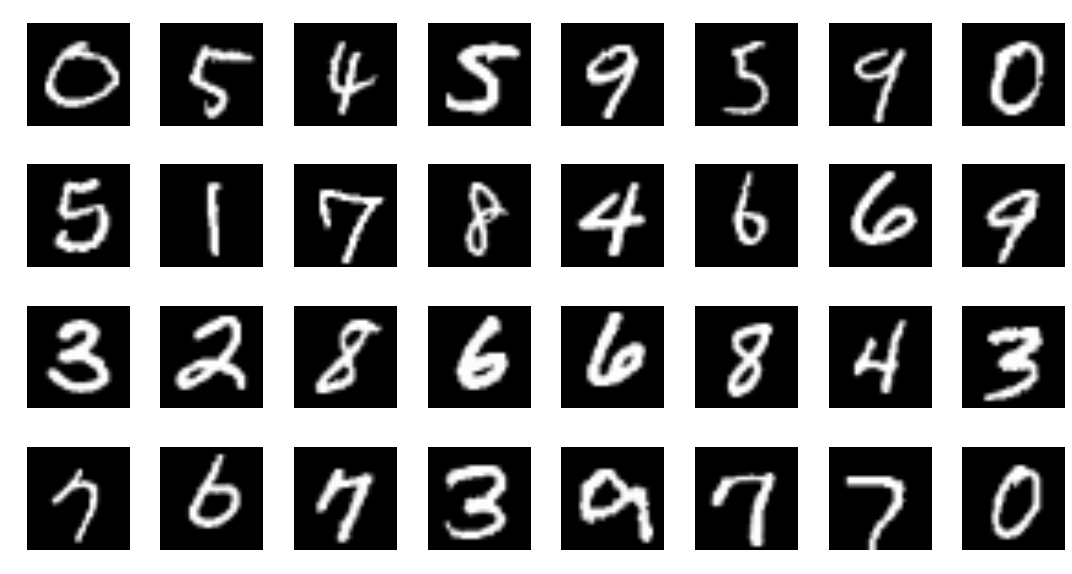

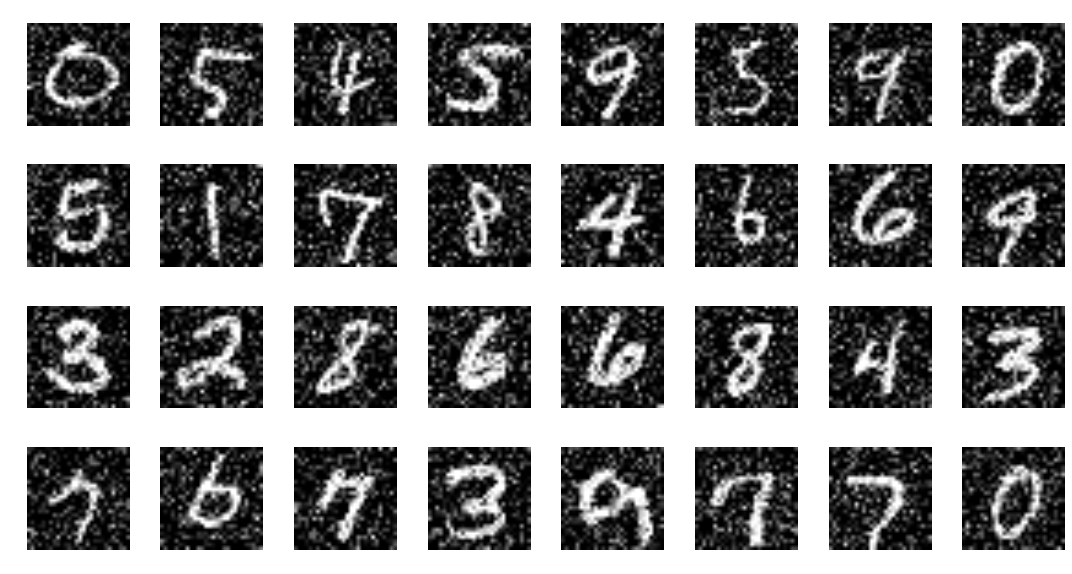

In [1]:
import torch

import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import Dataset

batch_size = 32

transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])


# datasets (MNIST)
mnist_train = datasets.MNIST('/data', train=True, download=True, transform=transform_train)
mnist_test = datasets.MNIST('/data', train=False, download=True, transform=transform_test)


class NoisyData(Dataset):
  def __init__(self, dataset, noise_level=0.3):
    super(NoisyData, self).__init__()
    self.dataset = dataset
    self.noise_level = noise_level
    
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    ##################  Change these lines  ####################################
    # TODO: return pair of clean and noisy image
    x_true, _ = self.dataset[idx]
    y_delta = torch.clamp(x_true + torch.randn(x_true.shape) * self.noise_level, 0, 1)
    return x_true, y_delta
    ##################  Finish changing here  ##################################
  
  
# dataloaders
train_loader = torch.utils.data.DataLoader(NoisyData(mnist_train), batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(NoisyData(mnist_test), batch_size=batch_size, shuffle=False, pin_memory=True)


def visualize_batch(batch, labels, ncols=8):
  nrows = (batch.shape[0] + ncols - 1) // ncols
  plt.figure(figsize=(15, 2*nrows))
  for i in range(batch.shape[0]):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(batch[i].permute(1, 2, 0).squeeze(),cmap='gray', interpolation='bilinear')
    plt.title(labels[i])
    plt.axis('off')
  plt.tight_layout()
  plt.show()

  
##################  Change these lines  ####################################
# TODO: Visualize the clean batch and the noisy batch

clean_batch, noisy_batch = next(iter(train_loader))
visualize_batch(clean_batch, [' '] * clean_batch.shape[0])
visualize_batch(noisy_batch, [' '] * clean_batch.shape[0])

##################  Finish changing here  ##################################

### Q2: Create the network

In [0]:
import torch.nn as nn

class Flatten(nn.Module):
    def forward(self, x):
        out = x.view(x.shape[0],-1)
        return out

class UnFlatten(nn.Module):
    def forward(self, x):
        out = x.view(x.shape[0], 1, 28, 28)
        return out

      
##################  Change these lines  ####################################
# TODO: Create an autoencoder
model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 14*14),
    nn.ReLU(),
    nn.Linear(14*14, 28*28),
    nn.Sigmoid(),
    UnFlatten()
)
##################  Finish changing here  ##################################      
  
  
class UNet(nn.Module):
    def __init__(self, in_ch, out_ch, channels=(8, 16, 32, 64)):
        super(UNet, self).__init__()
        self.scales = len(channels)
        
        self.down = nn.ModuleList()
        self.up = nn.ModuleList()
        
        self.inc = nn.Sequential(nn.Conv2d(in_ch, channels[0], 3, stride=1, padding=1),
                                 nn.BatchNorm2d(channels[0]),
                                 nn.LeakyReLU(0.2, inplace=True))
        
        for i in range(1, self.scales):
            self.down.append(DownBlock(channels[i-1], channels[i]))
        for i in range(1, self.scales):
            self.up.append(UpBlock(channels[-i], channels[-i-1]))

        self.outc = nn.Conv2d(channels[0], out_ch, kernel_size=1, stride=1)

    def forward(self, x0):
        xs = [self.inc(x0),]
        for i in range(self.scales-1):
            xs.append(self.down[i](xs[-1]))
        x = xs[-1]
        for i in range(self.scales-1):
            x = self.up[i](x, xs[-2-i])

        return torch.sigmoid(self.outc(x))


class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DownBlock, self).__init__()

        self.conv = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, stride=2, padding=1),
                                  nn.BatchNorm2d(out_ch),
                                  nn.LeakyReLU(0.2, inplace=True),
                                  nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
                                  nn.BatchNorm2d(out_ch),
                                  nn.LeakyReLU(0.2, inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x


class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UpBlock, self).__init__()

        self.conv = nn.Sequential(nn.BatchNorm2d(in_ch + 4),
                                  nn.Conv2d(in_ch + 4, out_ch, 3, stride=1, padding=1),
                                  nn.BatchNorm2d(out_ch),
                                  nn.LeakyReLU(0.2, inplace=True),
                                  nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
                                  nn.BatchNorm2d(out_ch),
                                  nn.LeakyReLU(0.2, inplace=True))

        self.skip_conv = nn.Sequential(nn.Conv2d(out_ch, 4, kernel_size=1, stride=1),
                                           nn.BatchNorm2d(4),
                                           nn.LeakyReLU(0.2, inplace=True))

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x2 = self.skip_conv(x2)
        x = torch.cat((x1, x2), dim=1)
        x = self.conv(x)
        return x
      
      
model = UNet(1, 1, channels=(8, 16))

### Q3: Set the hyperparameters, the loss function and the optimizer
a) Try first with SGD and then with the Adam optimization method

In [3]:
# learning rate
lr = 0.1

# number of epochs
n_epochs = 5

##################  Change these lines  ####################################
# TODO: Choose the loss function

lossf = torch.nn.MSELoss()

##################  Finish changing here  ##################################


optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# set device to use
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda


UNet(
  (down): ModuleList(
    (0): DownBlock(
      (conv): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.2, inplace)
      )
    )
  )
  (up): ModuleList(
    (0): UpBlock(
      (conv): Sequential(
        (0): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(20, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): LeakyReLU(negative_slope=0.2, inplace)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

### Q4: Train the network

In [4]:
from skimage.measure import compare_psnr

# iterate on epochs
for i in range(n_epochs):
  
  train_loss = 0.0
  test_loss = 0.0
  
  
  model.train()
  # iterate on batches
  for clean, noisy in train_loader:
    clean, noisy = clean.to(device), noisy.to(device)
    
    ##################  Change these lines  ####################################
    # TODO: Compute the output and do the backprop
    outputs = model(noisy)
    loss = lossf(outputs, clean)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ##################  Change these lines  ####################################
    
    for j in range(noisy.shape[0]):
      train_loss += compare_psnr(clean[j].detach().cpu().numpy(), outputs[j].detach().cpu().numpy())
      
    
    
  
  model.eval()
  # iterate on batches
  for clean, noisy in test_loader:
    clean, noisy = clean.to(device), noisy.to(device)
    outputs = model(noisy)
    loss = lossf(outputs, clean)
    
    for j in range(noisy.shape[0]):
      test_loss += compare_psnr(clean[j].detach().cpu().numpy(), outputs[j].detach().cpu().numpy())
    
  train_loss /= len(mnist_train)
  test_loss /= len(mnist_test)
  
  print('epoch: %d train-error: %.4f test-error: %.4f' % (i, train_loss, test_loss))

epoch: 0 train-error: 22.7686 test-error: 23.3046
epoch: 1 train-error: 23.3399 test-error: 23.0965
epoch: 2 train-error: 23.5066 test-error: 23.6398
epoch: 3 train-error: 23.5626 test-error: 23.4167
epoch: 4 train-error: 23.6668 test-error: 23.7408


### Q5: Show some examples

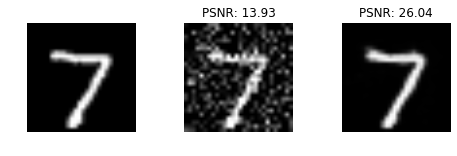

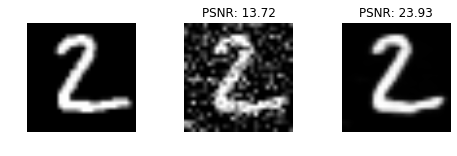

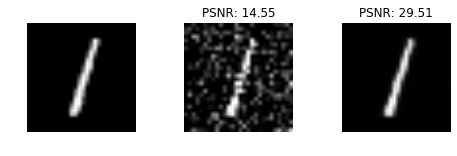

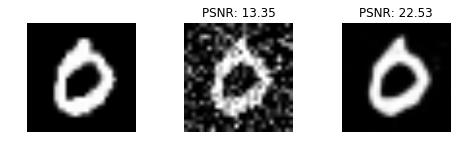

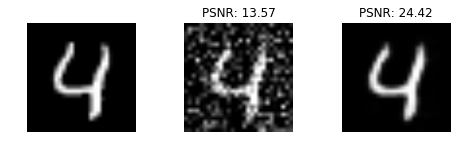

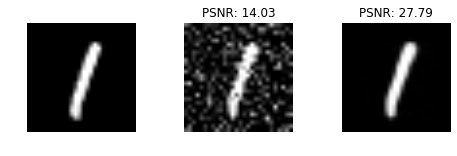

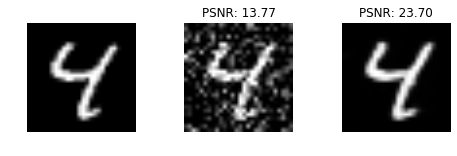

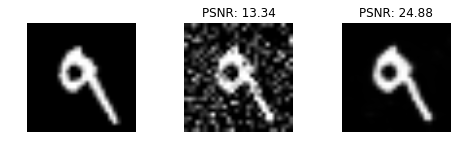

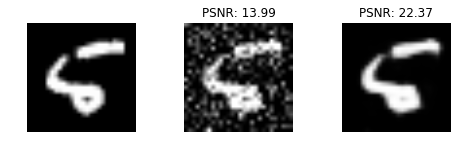

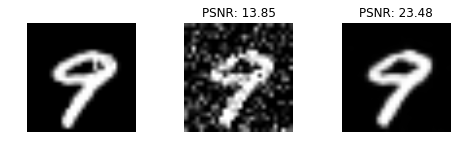

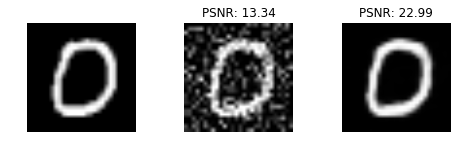

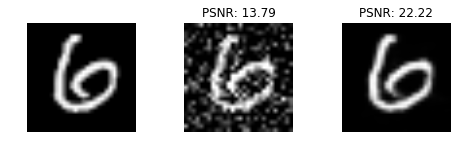

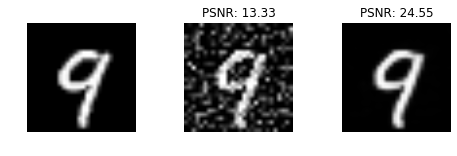

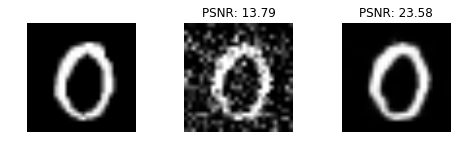

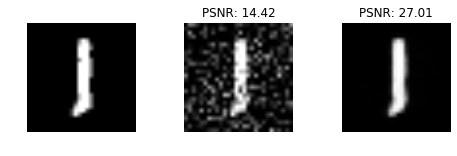

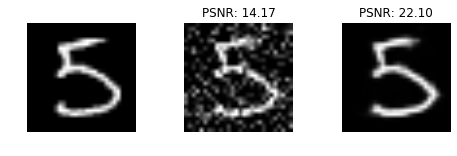

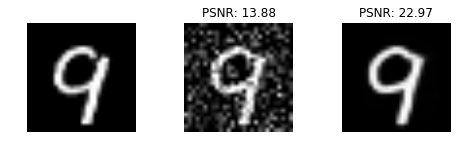

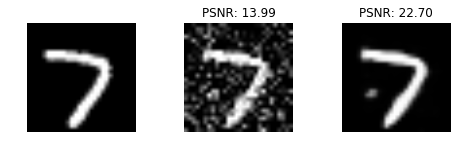

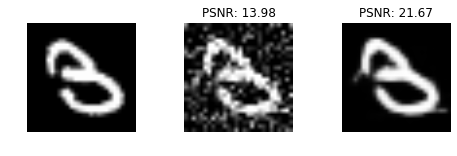

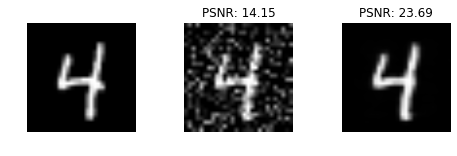

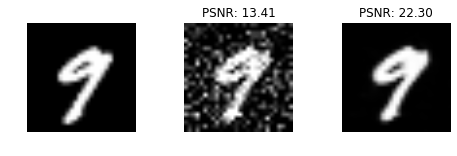

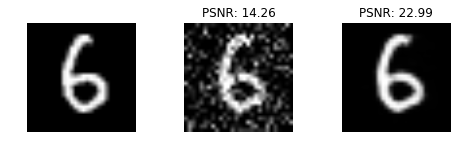

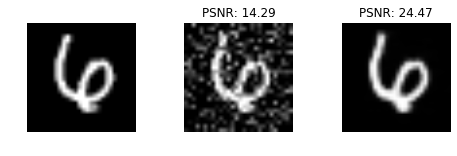

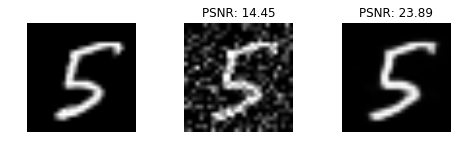

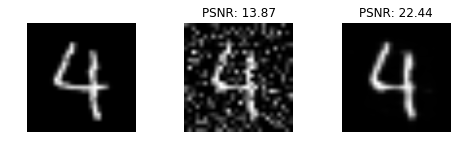

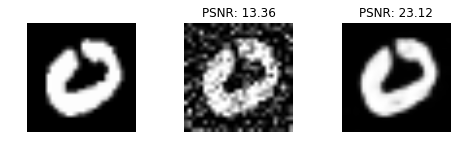

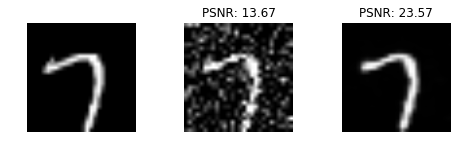

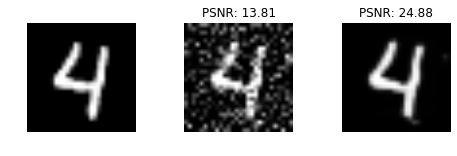

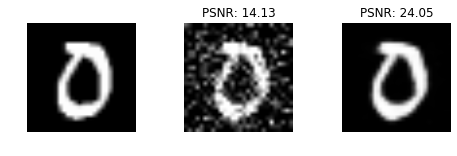

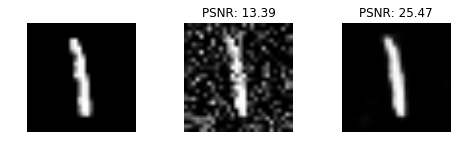

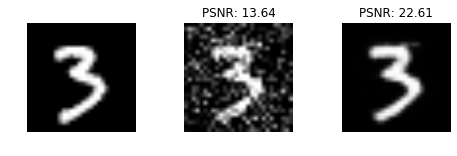

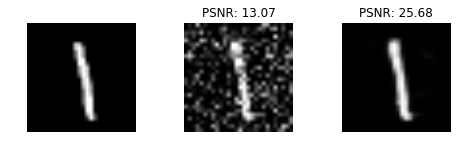

In [5]:
import torch.nn.functional as F

model.to(device)
model.eval()
clean, noisy = next(iter(test_loader))
outputs = model(noisy.to(device)).detach().cpu()


for i in range(noisy.shape[0]):
    plt.figure(figsize=(8,2))
   
    
    plt.subplot(1,3,1)
    
    plt.imshow(clean[i].permute(1, 2, 0).squeeze(), cmap='gray', interpolation='bilinear')
    plt.axis('off')
    
    plt.subplot(1,3,2)
    psnr1 = compare_psnr(noisy[i].detach().cpu().numpy(), outputs[i].detach().cpu().numpy())
    plt.title('PSNR: %.2f' % psnr1)
    plt.imshow(noisy[i].permute(1, 2, 0).squeeze(), cmap='gray', interpolation='bilinear')
    plt.axis('off')

    plt.subplot(1,3,3)
    psnr2 = compare_psnr(clean[i].detach().cpu().numpy(), outputs[i].detach().cpu().numpy())
    plt.imshow(outputs[i].permute(1, 2, 0).squeeze(), cmap='gray', interpolation='bilinear')
    plt.title('PSNR: %.2f' % psnr2)
    plt.axis('off')
    
    plt.show()